In [1]:
import pandas as pd
import gym
import matplotlib.pyplot as plt
from gym import spaces
import numpy as np
from numpy import load
import torch
import gc

In [2]:
from Data.random_load import random_train_load
from Data.episode_load import EpisodeLoader

In [3]:
class MarketEnv(gym.Env):
    def __init__(self, env_config ):
        self.data = env_config['data']
        self.starting_money = env_config['starting_money']
        self.starting_stocks = env_config['starting_stocks']
        self.episode_length = env_config['episode_length']
        self.commission = env_config['commission']
        
        self.loader = EpisodeLoader(self.data, episode_length = self.episode_length)
        self.high, self.low = self.loader.get_high_low()
        #Change high low to be env specific
        self.modify_high_low()
        
        self.observation_space = spaces.Box(high = np.inf, low = -np.inf, shape = (len(self.high),))
        self.action_space = self.set_action_space()
        
    def modify_high_low(self,):
        pass
    
    def set_action_space(self,):
        return NotImplemented
    
    def modify_state(self, state):
        return state
    
    def extract_action_info(self, action):
        return NotImplemented
    
    def do_action(self, action_info):
        return NotImplemented
    
    def reset(self,):
        self.current_money = self.starting_money
        self.current_stocks = self.starting_stocks
        self.tick = 0
        self.data = self.loader.get_episode()
        self.episode_length = len(self.data)
        state = self.data.iloc[self.tick]     
        self.current_price = state['price']
        state = state.values
        # Change state to be env specific
        state = self.modify_state(state)
        return state.copy()
    
    def test(self,):
        self.current_money = self.starting_money
        self.current_stocks = self.starting_stocks
        self.tick = 0
        self.data = self.loader.get_test()
        self.episode_length = len(self.data)   
        state = self.data.iloc[self.tick]     
        self.current_price = state['price']
        state = state.values
        # Change state to be env specific
        state = self.modify_state(state)
        return state.copy()
    
    def sell(self, amount):
        if amount > self.current_stocks:
            self.punish()
        else:
            stock_delta = -amount
            cash_delta = amount * self.current_price * (1 - self.commission)
            self.current_stocks += stock_delta
            self.current_money += cash_delta
            
        trade_info = [stock_delta, cash_delta]
            
        return trade_info
    
    def buy(self, amount):
        if amount > self.current_money:
            self.punish()
        else:
            stock_delta = amount * (1-self.commission)/self.current_price
            cash_delta = -amount
            self.current_stocks += stock_delta
            self.current_money += cash_delta
            
        trade_info = [stock_delta, cash_delta]
            
        return trade_info
        
    def step(self, action):
        action_info = self.extract_action_info(action)
        return self.do_action(action_info)
        

In [4]:
conf = {'curiosity_reward':150,
        'continuous':False,
        'data': 'Data/ground_truth/',
        'starting_money': 1000,
        'starting_stocks': 0,
        'episode_length': 10000,
        'commission': 0.0025
        }

In [5]:
class SimpleMarket(MarketEnv):
    def __init__(self, env_config = conf):
        self.is_continuous = env_config['continuous']
        super().__init__(env_config)
    def modify_high_low(self,):
        self.high = np.append(self.high, [100., 2000., 1000., self.high[-1]])
        self.low = np.append(self.low, [0., 0., 0., self.low[-1]])
        
    def set_action_space(self,):
        if self.is_continuous == False:
            self.action_space = spaces.Discrete(7) # buy/sell 10/50/100% + hold
        else:
            self.action_space = spaces.Box(high = 1, low = -1, shape = (1,))
            
    def modify_state(self, state):
        not_liquid_assets = self.current_price * self.current_stocks
        percentage_in_cash = 100 * (self.current_money/(self.current_money + not_liquid_assets))
        state = np.append(state, [percentage_in_cash, self.current_money, not_liquid_assets, self.zero_line])
        return state
    
    def reset(self,):
        self.zero_line = 0
        state = super().reset()
        return state
    
    def test(self, ):
        self.zero_line = 0
        state = super().test()
        return state
    
    def extract_action_info(self, action):
        if self.is_continuous:            
            if action > 0:
                action_type = 'buy'
            elif action == 0:
                action_type = 'hold'
            elif action < 0:
                action_type = 'sell'
            percentage = abs(action[0])
        else:
            action_dict = {0:0,
                           1:0.1,
                           2:0.2,
                           3:0.5,
                           4:0.1,
                           5:0.5,
                           6:1
                }
            if action == 0:
                action_type = 'hold'
            elif action < 4:
                action_type = 'buy'
            else:
                action_type = 'sell'
         
            percentage = action_dict[action]
        if action_type == 'sell' and self.current_stocks == 0:
            action_type = 'hold'
        elif action_type == 'buy' and self.current_money == 0:
            action_type = 'hold'
        return (action_type, percentage)
    
    def calculate_reward(self, transaction_info):
        stock_delta = transaction_info[0]
        cash_delta = transaction_info[1]
        if stock_delta > 0:
            reward = self.commission * cash_delta
        elif stock_delta < 0:
            reward = (self.current_price * (1 - self.commission) - self.zero_line) * abs(stock_delta)
        else:
            reward = 0
        return reward 
    
    def update_zero_line(self, buy_info):
        stock_delta = buy_info[0]
        self.zero_line = (self.zero_line * self.current_stocks + stock_delta * self.current_price)/(self.current_stocks + stock_delta)
    
    def normalize_state(self, state):
        normalized_state = (state - self.low)/(self.high - self.low)
        
        return normalized_state
    
    def do_action(self, action_info):
        done = 0
        action_type, percentage = action_info
        if action_type == 'hold':
            trade_info = [0,0]
        elif action_type == 'buy':
            amount = percentage * self.current_money
            trade_info = self.buy(amount)
            self.update_zero_line(trade_info)
        elif action_type == 'sell':
            amount = percentage * self.current_stocks
            trade_info = self.sell(amount)
            if self.current_stocks == 0:
                self.zero_line = 0        
        reward = self.calculate_reward(trade_info)
        
        self.tick += 1
        if self.tick == len(self.data)-1:
            done = 1
        self.current_price = self.data['price'][self.tick]
        next_state = self.data.iloc[self.tick].values
        next_state = self.modify_state(next_state)
        next_state = self.normalize_state(next_state)
        return next_state, reward, done, {}

In [6]:
market = SimpleMarket()

In [7]:
market.reset()
actions = []
assets = []
prices = []
done = 0
while done == 0:
    action = np.random.randint(7)
    next_state, reward, done, info = market.step(action)
    asset = market.current_price * market.current_stocks + market.current_money
    actions.append(action)
    assets.append(asset)
    prices.append(market.current_price)
print(prices[-1]/prices[0])
print(assets[-1]/assets[0])

1.1997730772347839
0.023113382766805197


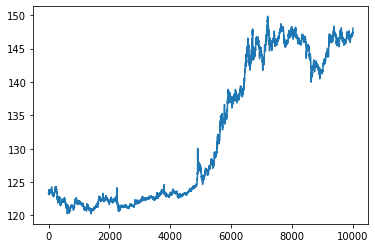

In [8]:
plt.plot(prices)

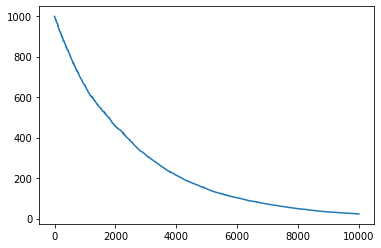

In [9]:
plt.plot(assets)